In [1]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score

import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn; sns.set(rc={'figure.figsize':(12,10)})
import tensorflow as tf
import keras

pd.set_option('display.max_columns', 500)

# Data-loading

In [2]:
subscriptions_rds = pd.read_csv("subscriptions_mix.csv")
subscriptions_dtypes_modified = False

C:\Users\Michail\AppData\Local\Temp\ipykernel_24688\4161518358.py:1: DtypeWarning: Columns (4,6,10,13,16,18,20,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  subscriptions_rds = pd.read_csv("subscriptions_mix.csv")


In [3]:
transactions_rds = pd.read_csv("transactions_mix.csv")

C:\Users\Michail\AppData\Local\Temp\ipykernel_24688\1978939114.py:1: DtypeWarning: Columns (4,6,10,13,14,15,16,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  transactions_rds = pd.read_csv("transactions_mix.csv")


In [4]:
subscriptions_rds

,id,created_at,country,operator,service,source,msisdn,status,cycle,adnet,revenue,subs_date,renewal_date,freemium_end_date,unsubs_from,unsubs_date,service_price,currency,profile_status,publisher,trxid,pixel,handset,browser,attempt_charging,success_billing
0,302164.0,2023-09-13 09:47:57.713,TH,ais,459505104,sms,66988602911,0.0,daily,NaN,0,2022-10-20 19:28:02.000,2023-09-14 00:00:00.000,2022-10-20 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230900000000000000.0,NaN,NaN,NaN,15.0,0.0
1,3521.0,2023-09-13 09:21:13.679,TH,ais,459505104,sms,66822243080,0.0,daily,NaN,0,2020-08-23 16:11:02.000,2023-09-14 00:00:00.000,2020-08-23 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230900000000000000.0,NaN,NaN,NaN,15.0,0.0
2,1.0,2023-09-13 09:20:20.727,TH,ais,459505106,ivr,666131,0.0,1,NaN,6,2023-08-25 14:02:05.000,2023-08-26 00:00:00.000,2023-08-25 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230800000000000000.0,NaN,NaN,NaN,1.0,1.0
3,4999335.0,2023-09-13 14:00:22.171,TH,ais,459505105,wap,66650020857,0.0,daily,star,0,2023-09-09 13:03:24.000,2023-09-14 00:00:00.000,2023-09-09 00:00:00.000,NaN,NaN,6,BATH,Active,star,20230900000000000000.0,star-APP1694223212644066,NaN,NaN,5.0,0.0
4,273196.0,2023-09-13 09:45:33.449,TH,ais,459505104,sms,66635959286,0.0,daily,NaN,0,2022-09-26 19:36:03.000,2023-09-14 00:00:00.000,2022-09-26 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230900000000000000.0,NaN,NaN,NaN,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Subscription

In [5]:
if not subscriptions_dtypes_modified:

    subscriptions_rds.dropna(how='all', inplace=True)

    subscriptions_rds = subscriptions_rds.loc[(subscriptions_rds['revenue'].astype(str).str.isnumeric()) & (subscriptions_rds['service_price'].astype(str).str.isnumeric())]

    subscriptions_rds['country'] = subscriptions_rds['country'].str.upper()
    subscriptions_rds['status'] = subscriptions_rds['status'].astype(int)
    subscriptions_rds['revenue'] = subscriptions_rds['revenue'].astype(float)
    subscriptions_rds['service_price'] = subscriptions_rds['service_price'].astype(float).astype(int)
    subscriptions_rds['currency'] = subscriptions_rds['currency'].fillna('XOF').str.upper()
    subscriptions_rds['attempt_charging'] = subscriptions_rds['attempt_charging'].astype(int)
    subscriptions_rds['success_billing'] = subscriptions_rds['success_billing'].astype(int)


    column_to_datetime = ['created_at', 'subs_date', 'renewal_date', 'freemium_end_date', 'unsubs_date']

    for column in column_to_datetime:
        subscriptions_rds[column] = pd.to_datetime(subscriptions_rds[column], errors='coerce')

    subscriptions_dtypes_modified = True

subscriptions_rds['country'].unique()

C:\Users\Michail\AppData\Local\Temp\ipykernel_24688\1645250189.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subscriptions_rds['country'] = subscriptions_rds['country'].str.upper()
C:\Users\Michail\AppData\Local\Temp\ipykernel_24688\1645250189.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subscriptions_rds['status'] = subscriptions_rds['status'].astype(int)
C:\Users\Michail\AppData\Local\Temp\ipykernel_24688\1645250189.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

array(['TH', 'SN', 'LA', 'OM'], dtype=object)

In [6]:
def ToIDRMultiplier(str):
    if str == 'BATH': return 440
    if str == 'RIAL' : return 3900
    if str == 'XOF' : return 23
    return 0.8

def ToLocalHour(str):
    if str == 'TH' or str == 'LA' : return 0
    if str == 'SN' : return -7
    return -3
    

# Data processing

In [7]:
subscriptions_mds = subscriptions_rds.drop(columns = 
    ['id',
     'created_at',
     'trxid', 
     'adnet',
     'browser',
     'handset',
     'pixel',
     'publisher',
     'service',
     'profile_status',
     'unsubs_from',
     'pixel',
     'browser',
     'status'])

drop_row = ((subscriptions_mds['cycle'] == '1') |
            (subscriptions_mds['subs_date'] > subscriptions_mds['unsubs_date']) |
            (subscriptions_mds['attempt_charging'] < subscriptions_mds['success_billing']))

subscriptions_mds.drop(drop_row[drop_row].index, inplace=True)

subscriptions_mds['subs_date_month'] = subscriptions_mds['subs_date'].dt.month

subscriptions_mds['subs_date_hour'] = subscriptions_mds['subs_date'].dt.hour
subscriptions_mds['subs_date_hour_local'] = (subscriptions_mds['subs_date_hour'] + subscriptions_mds['country'].apply(ToLocalHour)).apply(lambda x : x+24 if x < 0 else x)

subscriptions_mds['revenue_converted'] = subscriptions_mds['currency'].apply(ToIDRMultiplier) * subscriptions_mds['revenue']
subscriptions_mds['service_price_converted'] = subscriptions_mds['currency'].apply(ToIDRMultiplier) * subscriptions_mds['service_price']

subscriptions_mds['success_billing_rate'] = (subscriptions_mds['success_billing'] / subscriptions_mds['attempt_charging']).fillna(0)

subscriptions_mds['years_subscribed'] = (subscriptions_mds['unsubs_date'].fillna(pd.Timestamp(year=2023, month=10, day=1)) - subscriptions_mds['subs_date']) / pd.Timedelta(days=365)

status_index = subscriptions_mds['unsubs_date'].notna().astype(str).replace('False', None).replace('True', '-1')
status_index[status_index.isna()] = subscriptions_mds.loc[status_index.isna()]['renewal_date'].notna().astype(str).replace('False', 0).replace('True', '1')
subscriptions_mds['status'] = status_index.astype(int)

encoder = LabelEncoder()

subscriptions_mds['source_encoded'] = encoder.fit_transform(subscriptions_mds['source'])
subscriptions_mds['country_encoded'] = encoder.fit_transform(subscriptions_mds['country'])
subscriptions_mds['operator_encoded'] = encoder.fit_transform(subscriptions_mds['operator'])
subscriptions_mds['cycle_encoded'] = encoder.fit_transform(subscriptions_mds['cycle'])

bins = [0, 0.01, 1]
labels = ['bad', 'good']
subscriptions_mds['success_billing_rate_binned'] = pd.cut(subscriptions_mds['success_billing_rate'], bins=bins, labels=labels, include_lowest=True)

subscriptions_mds

,country,operator,source,msisdn,cycle,revenue,subs_date,renewal_date,freemium_end_date,unsubs_date,service_price,currency,attempt_charging,success_billing,subs_date_month,subs_date_hour,subs_date_hour_local,revenue_converted,service_price_converted,success_billing_rate,years_subscribed,status,source_encoded,country_encoded,operator_encoded,cycle_encoded,success_billing_rate_binned
0,TH,ais,sms,66988602911,daily,0.0,2022-10-20 19:28:02,2023-09-14 00:00:00,2022-10-20,NaT,6,BATH,15,0,10,19,19,0.0,2640.0,0.000000,0.945723,1,7,3,0,0,bad
1,TH,ais,sms,66822243080,daily,0.0,2020-08-23 16:11:02,2023-09-14 00:00:00,2020-08-23,NaT,6,BATH,15,0,8,16,16,0.0,2640.0,0.000000,3.105002,1,7,3,0,0,bad
3,TH,ais,wap,66650020857,daily,0.0,2023-09-09 13:03:24,2023-09-14 00:00:00,2023-09-09,NaT,6,BATH,5,0,9,13,13,0.0,2640.0,0.000000,0.058783,1,8,3,0,0,bad
4,TH,ais,sms,66635959286,daily,0.0,2022-09-26 19:36:03,2023-09-14 00:00:00,2022-09-26,NaT,6,BATH,15,0,9,19,19,0.0,2640.0,0.000000,1.011461,1,7,3,0,0,bad
5,TH,ais,sms,66931235277,daily,0.0,2021-08-06 16:27:07,2023-09-14 00:00:00,2021-08-06,NaT,6,BATH,15,0,8,16,16,0.0,2640.0,0.000000,2.151547,1,7,3,0,0,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294907,OM,omantel,cp1,96899385640,daily,37500.0,2023-01-08 08:11:33,2023-05-12 06:23:11,NaT,NaT,300,RIAL,125,125,1,8,5,146250000.0,1170000.0,1.000000,0.727832,1,2,1,2,0,good
294908,OM,omantel,cp1,96899692670,daily,24900.0,2023-01-08 07:43:45,2023-05-12 06:20:31,NaT,NaT,300,RIAL,84,83,1,7,4,97110000.0,1170000.0,0.988095,0.727885,1,2,1,2,0,good
294909,OM,omantel,cp1,96891308962,daily,0.0,2023-01-08 12:23:17,2023-01-08 12:25:07,NaT,2023-03-10 03:07:13,300,RIAL,1,0,1,12,9,0.0,1170000.0,0.000000,0.166065,-1,2,1,2,0,bad
294910,OM,omantel,cp1,96891246065,daily,1800.0,2023-01-08 16:56:17,2023-04-19 05:55:05,NaT,NaT,300,RIAL,7,6,1,16,13,7020000.0,1170000.0,0.857143,0.726834,1,2,1,2,0,good


# Learning Model

## Random Forest Regressor

In [8]:
columns_to_encode = ['country', 'operator', 'source', 'cycle']

data_sample = pd.concat([
    subscriptions_mds[(subscriptions_mds['subs_date'] < pd.Timestamp(year=2022, month=10, day=1)) &
                      subscriptions_mds['success_billing_rate'].notna() &
                      (subscriptions_mds['success_billing_rate'] > 0).sample(12000)],
    subscriptions_mds[subscriptions_mds['success_billing'] == 0].sample(12000)])

encoding_df = pd.DataFrame(index=data_sample.index)
for column in columns_to_encode:
    encoding_df = pd.concat([encoding_df,
                             pd.get_dummies(data_sample[column].astype(pd.CategoricalDtype(categories=subscriptions_mds[column].unique())), 
                                            dummy_na=True)],
                            axis=1)

X = data_sample[['attempt_charging', 'subs_date_month', 'subs_date_hour']]

X = pd.concat([encoding_df, X], axis=1)
X.columns = X.columns.astype(str)

y = data_sample['success_billing']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

reg = RandomForestRegressor(max_depth=10)
reg.fit(X_train, y_train)

offset = 1

mean_sqr_err = mean_squared_error(reg.predict(X_test)*offset, y_test*offset)
print(f'Mean squared error: {mean_sqr_err}')

C:\Users\Michail\AppData\Local\Temp\ipykernel_24688\3075808954.py:11: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  encoding_df = pd.concat([encoding_df,


Mean squared error: 0.04288114090903995


## Model Validation

In [9]:
columns_to_encode = ['country', 'operator', 'source', 'cycle']

data_sample = subscriptions_mds

encoding_df = pd.DataFrame(index=data_sample.index)
for column in columns_to_encode:
    encoding_df = pd.concat([encoding_df,
                             pd.get_dummies(data_sample[column].astype(pd.CategoricalDtype(categories=subscriptions_mds[column].unique())), 
                                            dummy_na=True)],
                            axis=1)

X = data_sample[['attempt_charging', 'subs_date_month', 'subs_date_hour']]

X = pd.concat([encoding_df, X], axis=1)
X.columns = X.columns.astype(str)

y = data_sample['success_billing']

y_pred = reg.predict(X)

mean_sqr_err = mean_squared_error(y_pred, y)
print(f'Mean squared error: {mean_sqr_err}')

df = pd.concat([y, pd.Series(y_pred, index=y.index, name='success_billing_prediction')], axis=1)
df

C:\Users\Michail\AppData\Local\Temp\ipykernel_24688\3314699509.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  encoding_df = pd.concat([encoding_df,


Mean squared error: 7.932467512532152


,success_billing,success_billing_prediction
0,0,0.009227
1,0,0.034851
3,0,0.000000
4,0,0.030174
5,0,0.034851
...,...,...
294907,125,54.520000
294908,83,54.520000
294909,0,0.014473
294910,6,5.440000


## Random Forest Classification

In [10]:
columns_to_encode = ['operator', 'cycle']

data_sample = pd.concat([
    subscriptions_mds[(subscriptions_mds['subs_date'] < pd.Timestamp(year=2022, month=10, day=1)) &
                      subscriptions_mds['success_billing_rate'].notna() &
                      (subscriptions_mds['success_billing_rate'] > 0.)],
    subscriptions_mds[subscriptions_mds['success_billing'] == 0].sample(6000)])

encoding_df = pd.DataFrame(index=data_sample.index)
for column in columns_to_encode:
    encoding_df = pd.concat([encoding_df,
                             pd.get_dummies(data_sample[column].astype(pd.CategoricalDtype(categories=subscriptions_mds[column].unique())), 
                                            dummy_na=True)],
                            axis=1)



X = data_sample[['attempt_charging', 'subs_date_month', 'subs_date_hour', 'subs_date_hour_local']]

X = pd.concat([encoding_df, X], axis=1)
X.columns = X.columns.astype(str)

y = data_sample['success_billing_rate_binned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = RandomForestClassifier(max_depth=5)
clf.fit(X_train, y_train)

acc_score = accuracy_score(clf.predict(X_test), y_test)
print(f'Accuracy_score: {acc_score}')

Accuracy_score: 0.7278887303851641


C:\Users\Michail\AppData\Local\Temp\ipykernel_24688\106533085.py:11: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  encoding_df = pd.concat([encoding_df,


## Model Validation

In [11]:
columns_to_encode = ['operator', 'cycle']

data_sample = subscriptions_mds
encoding_df = pd.DataFrame(index=data_sample.index)
for column in columns_to_encode:
    encoding_df = pd.concat([encoding_df,
                             pd.get_dummies(data_sample[column].astype(pd.CategoricalDtype(categories=subscriptions_mds[column].unique())), 
                                            dummy_na=True)],
                            axis=1)

X = data_sample[['attempt_charging', 'subs_date_month', 'subs_date_hour', 'subs_date_hour_local']]

X = pd.concat([encoding_df, X], axis=1)
X.columns = X.columns.astype(str)

y = data_sample['success_billing_rate_binned']

pred_y = clf.predict(X)

acc_score = accuracy_score(pred_y, y)
print(f'Accuracy_score: {acc_score}')

df = pd.concat([pd.Series(pred_y, index=y.index), y], axis=1)

C:\Users\Michail\AppData\Local\Temp\ipykernel_24688\1774179093.py:6: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  encoding_df = pd.concat([encoding_df,


Accuracy_score: 0.9312781080875067


# Deep Learning

In [12]:
columns_to_encode = ['operator', 'cycle']

data_sample = pd.concat([
    subscriptions_mds[(subscriptions_mds['subs_date'] < pd.Timestamp(year=2022, month=10, day=1)) &
                      subscriptions_mds['success_billing_rate'].notna() &
                      (subscriptions_mds['success_billing_rate'] > 0.25)],
    subscriptions_mds[subscriptions_mds['success_billing'] == 0].sample(3000)])
encoding_df = pd.DataFrame(index=data_sample.index)
for column in columns_to_encode:
    encoding_df = pd.concat([encoding_df,
                             pd.get_dummies(data_sample[column].astype(pd.CategoricalDtype(categories=subscriptions_mds[column].unique())), 
                                            dummy_na=True)],
                            axis=1)

X = data_sample[['attempt_charging', 'subs_date_month', 'subs_date_hour', 'success_billing_rate']]

X = pd.concat([encoding_df, X], axis=1)

y = X['success_billing_rate']
X.drop(columns=['success_billing_rate'], inplace=True)

numeric_features = X.astype(int)

normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(numeric_features)

model = keras.Sequential([
normalizer,
keras.layers.Dense(100, activation='sigmoid'),
keras.layers.Dense(100, activation='sigmoid'),
keras.layers.Dense(50, activation='sigmoid'),
keras.layers.Dense(50, activation='sigmoid'),
keras.layers.Dense(50, activation='sigmoid'),
keras.layers.Dense(10, activation='relu'),
keras.layers.Dense(1)
])

model.compile(optimizer='rmsprop',
            loss=keras.losses.MeanSquaredError(),
            metrics=['accuracy'])

numeric_dataset = tf.data.Dataset.from_tensor_slices((numeric_features, y))
numeric_batches = numeric_dataset.shuffle(7000).batch(10)
model.fit(numeric_batches, epochs=10)
# y.describe()

C:\Users\Michail\AppData\Local\Temp\ipykernel_24688\1375209631.py:10: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  encoding_df = pd.concat([encoding_df,



Epoch 1/10


416/416 [==============================] - 1s 1ms/step - loss: 0.1232 - accuracy: 0.7401
Epoch 2/10
416/416 [==============================] - 0s 1ms/step - loss: 0.0361 - accuracy: 0.8198
Epoch 3/10
416/416 [==============================] - 0s 1ms/step - loss: 0.0346 - accuracy: 0.8200
Epoch 4/10
416/416 [==============================] - 0s 1ms/step - loss: 0.0342 - accuracy: 0.8203
Epoch 5/10
416/416 [==============================] - 0s 1ms/step - loss: 0.0335 - accuracy: 0.8203
Epoch 6/10
416/416 [==============================] - 0s 1ms/step - loss: 0.0333 - accuracy: 0.8203
Epoch 7/10
416/416 [==============================] - 0s 1ms/step - loss: 0.0331 - accuracy: 0.8203
Epoch 8/10
416/416 [==============================] - 0s 1ms/step - loss: 0.0327 - accuracy: 0.8203
Epoch 9/10
416/416 [==============================] - 0s 1ms/step - loss: 0.0325 - accuracy: 0.8205
Epoch 10/10
416/416 [==============================] - 0s 1ms/step - loss: 0.0323 - accuracy: 0.8

## Model Validation

In [13]:
columns_to_encode = ['operator', 'cycle']

data_sample = subscriptions_mds.sample(10000)

encoding_df = pd.DataFrame(index=data_sample.index)
for column in columns_to_encode:
    encoding_df = pd.concat([encoding_df,
                             pd.get_dummies(data_sample[column].astype(pd.CategoricalDtype(categories=subscriptions_mds[column].unique())), 
                                            dummy_na=True)],
                            axis=1)

X = data_sample[['attempt_charging', 'subs_date_month', 'subs_date_hour', 'success_billing_rate']]

X = pd.concat([encoding_df, X], axis=1)

y = X['success_billing_rate']
X.drop(columns=['success_billing_rate'], inplace=True)

numeric_features = X.astype(int)

y_pred = model.predict(numeric_features)

mean_abs_err = mean_absolute_error(y_pred, y)
print(f'Mean absolute error: {mean_abs_err}')

df = pd.concat([y, pd.Series(y_pred.ravel(), index=y.index, name='success_billing_rate_prediction')], axis=1)
df

 57/313 [====>.........................] - ETA: 0s 

C:\Users\Michail\AppData\Local\Temp\ipykernel_24688\2624936843.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  encoding_df = pd.concat([encoding_df,


313/313 [==============================] - 0s 879us/step
Mean absolute error: 0.051293050673346406


,success_billing_rate,success_billing_rate_prediction
14318,0.000000,0.053407
106748,0.000000,-0.006863
201609,0.000000,-0.016468
150717,0.000000,0.045533
183098,0.000000,0.053407
...,...,...
130462,0.000000,0.043602
204798,0.000000,-0.016988
181309,0.066667,0.052413
97336,0.000000,-0.010108


## Decision Tree Regressor

In [14]:
# columns_to_encode = ['country', 'operator', 'source', 'cycle']
# data_sample = pd.concat([
#     subscriptions_mds[(subscriptions_mds['subs_date'] < pd.Timestamp(year=2022, month=10, day=1)) &
#                       subscriptions_mds['success_billing_rate'].notna() &
#                       (subscriptions_mds['success_billing_rate'] > 0.25)],
#     subscriptions_mds[subscriptions_mds['success_billing'] == 0].sample(1200)])
# encoding_df = pd.DataFrame(index=data_sample.index)
# for column in columns_to_encode:
#     encoding_df = pd.concat([encoding_df,
#                              pd.get_dummies(data_sample[column].astype(pd.CategoricalDtype(categories=subscriptions_mds[column].unique())), 
#                                             dummy_na=True)],
#                             axis=1)

# X = data_sample[['attempt_charging', 'subs_date_month', 'subs_date_hour']]
# X = pd.concat([encoding_df, X], axis=1)
# X.columns = X.columns.astype(str)
# y = data_sample['success_billing_rate']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# dt_regressor = DecisionTreeRegressor(max_depth=10)
# dt_regressor.fit(X_train, y_train)
# y_pred_dt = dt_regressor.predict(X_test)
# y_pred_dt=100
# y_test=100
# mse_dt = mean_absolute_error(y_test, y_pred_dt)
# r2_dt = r2_score(y_test, y_pred_dt)

# print(f'Decision Tree Mean Absolute Error: {mse_dt}')
# print(f'Decision Tree R-squared: {r2_dt}')

# Visualization

In [15]:
year = 2020
month = 5
subscriptions_mds[(subscriptions_mds['subs_date'] >= pd.Timestamp(f'{year}-{month+1}')) &
                        (subscriptions_mds['subs_date'] < pd.Timestamp((f'{year + (1 if month + 1 == 12 else 0)}-{(month+1)%12 + 1}'))) & 
                        ((subscriptions_mds['unsubs_date'].isnull()) | (subscriptions_mds['unsubs_date'] >= pd.Timestamp(f'{year + (1 if month + 1 == 12 else 0)}-{(month+1)%12 + 1}')))]

,country,operator,source,msisdn,cycle,revenue,subs_date,renewal_date,freemium_end_date,unsubs_date,service_price,currency,attempt_charging,success_billing,subs_date_month,subs_date_hour,subs_date_hour_local,revenue_converted,service_price_converted,success_billing_rate,years_subscribed,status,source_encoded,country_encoded,operator_encoded,cycle_encoded,success_billing_rate_binned
61,TH,ais,sms,66935960259,daily,0.0,2020-06-02 02:52:02,2023-09-14,2020-06-01,NaT,6,BATH,15,0,6,2,2,0.0,2640.0,0.0,3.331180,1,7,3,0,0,bad
204,TH,ais,sms,66631018172,daily,0.0,2020-06-03 03:20:02,2023-09-14,2020-06-02,NaT,6,BATH,15,0,6,3,3,0.0,2640.0,0.0,3.328387,1,7,3,0,0,bad
443,TH,ais,sms,66935715767,daily,0.0,2020-06-10 18:35:01,2023-09-14,2020-06-10,NaT,6,BATH,15,0,6,18,18,0.0,2640.0,0.0,3.307468,1,7,3,0,0,bad
680,TH,ais,sms,66936099361,daily,0.0,2020-06-17 15:19:02,2023-09-14,2020-06-17,NaT,6,BATH,15,0,6,15,15,0.0,2640.0,0.0,3.288662,1,7,3,0,0,bad
999,TH,ais,sms,66987848064,daily,0.0,2020-06-11 15:06:01,2023-09-14,2020-06-11,NaT,6,BATH,15,0,6,15,15,0.0,2640.0,0.0,3.305126,1,7,3,0,0,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197673,TH,ais,sms,66871016257,daily,0.0,2020-06-14 15:26:01,2023-09-14,2020-06-14,NaT,6,BATH,15,0,6,15,15,0.0,2640.0,0.0,3.296868,1,7,3,0,0,bad
198480,TH,ais,sms,66652512544,daily,0.0,2020-06-02 16:09:02,2023-09-14,2020-06-02,NaT,6,BATH,15,0,6,16,16,0.0,2640.0,0.0,3.329663,1,7,3,0,0,bad
198928,TH,ais,sms,66986258255,daily,0.0,2020-06-09 21:12:02,2023-09-14,2020-06-09,NaT,6,BATH,15,0,6,21,21,0.0,2640.0,0.0,3.309909,1,7,3,0,0,bad
198983,TH,ais,sms,66980710074,daily,0.0,2020-06-15 15:41:02,2023-09-14,2020-06-15,NaT,6,BATH,15,0,6,15,15,0.0,2640.0,0.0,3.294100,1,7,3,0,0,bad


In [16]:
active_user_count_ds = []
for year in range(2020, 2024):
    for month in range(12):
        user_count = subscriptions_mds[(subscriptions_mds['subs_date'] >= pd.Timestamp(year=year, month=month+1, day=1)) &
                        (subscriptions_mds['subs_date'] < pd.Timestamp(year=year+(1 if month + 1 == 12 else 0), month=(month+1)%12 + 1, day=1)) & 
                        ((subscriptions_mds['unsubs_date'].isnull()) | (subscriptions_mds['unsubs_date'] >= pd.Timestamp(year=year + (1 if month + 1 == 12 else 0), month=(month+1)%12 + 1, day=1)))]['msisdn'].unique().size
        active_user_count_ds.append([year, month+1, user_count])

active_user_count_ds = active_user_count_ds[2:45]
        
active_user_count_ds = pd.DataFrame(data=active_user_count_ds, columns=['year', 'month', 'active_user_count'])
active_user_count_ds['time'] = active_user_count_ds['year'].astype(str) + '-' + active_user_count_ds['month'].astype(str)

,time,active_user_count
0,2020-03,1
1,2020-04,117
2,2020-05,316
3,2020-06,597
4,2020-07,438
5,2020-08,334
6,2020-09,55
7,2020-10,41
8,2020-11,0
9,2020-12,0


In [17]:
active_user_count_ds_h = []
for year in range(2020, 2024):
    for month in range(12):
        for hour in range(24):
            user_count = subscriptions_mds[(subscriptions_mds['subs_date'] >= pd.Timestamp(year=year, month=month+1, day=1)) &
                            (subscriptions_mds['subs_date'] < pd.Timestamp(year=year+(1 if month + 1 == 12 else 0), month=(month+1)%12 + 1, day=1)) & 
                            ((subscriptions_mds['unsubs_date'].isnull()) | (subscriptions_mds['unsubs_date'] >= pd.Timestamp(year=year + (1 if month + 1 == 12 else 0), month=(month+1)%12 + 1, day=1))) &
                            (subscriptions_mds['subs_date'].dt.hour == hour)]['msisdn'].unique().size
            active_user_count_ds_h.append([year, month+1, hour, user_count])
        
active_user_count_ds_h = pd.DataFrame(data=active_user_count_ds_h, columns=['year', 'month', 'month', 'active_user_count'])

,country,operator,source,msisdn,cycle,revenue,subs_date,renewal_date,freemium_end_date,unsubs_date,service_price,currency,attempt_charging,success_billing,subs_date_month,subs_date_hour,revenue_converted,service_price_converted,success_billing_rate,years_subscribed,status,source_encoded,country_encoded,operator_encoded,cycle_encoded,success_billing_rate_binned
22,TH,ais,sms,66613532529,daily,0.0,2021-11-12 00:18:04,2023-09-01,2021-11-11,NaT,6,BATH,0,0,11,0,0.0,2640.0,0.000000,1.884897,1,7,3,0,0,bad
49,TH,ais,sms,66621293049,daily,0.0,2021-11-19 04:35:04,2023-09-01,2021-11-18,NaT,6,BATH,0,0,11,4,0.0,2640.0,0.000000,1.865230,1,7,3,0,0,bad
144,TH,ais,sms,66621622838,daily,0.0,2021-11-15 19:33:03,2023-09-01,2021-11-15,NaT,6,BATH,0,0,11,19,0.0,2640.0,0.000000,1.874480,1,7,3,0,0,bad
177,TH,ais,sms,66984159540,daily,0.0,2021-11-03 03:12:03,2023-09-14,2021-11-02,NaT,6,BATH,15,0,11,3,0.0,2640.0,0.000000,1.909224,1,7,3,0,0,bad
180,TH,ais,sms,66631208124,daily,0.0,2021-11-10 03:53:03,2023-09-14,2021-11-09,NaT,6,BATH,15,0,11,3,0.0,2640.0,0.000000,1.889968,1,7,3,0,0,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199301,TH,ais,sms,66821374501,daily,0.0,2021-11-02 20:19:04,2023-09-14,2021-11-02,NaT,6,BATH,15,0,11,20,0.0,2640.0,0.000000,1.910009,1,7,3,0,0,bad
199658,TH,ais,sms,66653230577,daily,0.0,2021-11-10 18:38:02,2023-09-14,2021-11-10,NaT,6,BATH,15,0,11,18,0.0,2640.0,0.000000,1.888284,1,7,3,0,0,bad
199774,TH,ais,sms,66934572843,daily,0.0,2021-11-07 20:09:04,2023-09-14,2021-11-07,NaT,6,BATH,15,0,11,20,0.0,2640.0,0.000000,1.896330,1,7,3,0,0,bad
199900,TH,ais,sms,66985276610,daily,6.0,2021-11-09 20:47:04,2023-09-14,2021-11-09,NaT,6,BATH,15,1,11,20,2640.0,2640.0,0.066667,1.890778,1,7,3,0,0,good


In [18]:
year=2021
month=10
subscriptions_mds[(subscriptions_mds['subs_date'] >= pd.Timestamp(year=year, month=month+1, day=1)) &
                        (subscriptions_mds['subs_date'] < pd.Timestamp(year=year+(1 if month + 1 == 12 else 0), month=(month+1)%12 + 1, day=1)) & 
                        ((subscriptions_mds['unsubs_date'].isnull()) | (subscriptions_mds['unsubs_date'] >= pd.Timestamp(year=year + (1 if month + 1 == 12 else 0), month=(month+1)%12 + 1, day=1)))]

,country,operator,source,msisdn,cycle,revenue,subs_date,renewal_date,freemium_end_date,unsubs_date,service_price,currency,attempt_charging,success_billing,subs_date_month,subs_date_hour,subs_date_hour_local,revenue_converted,service_price_converted,success_billing_rate,years_subscribed,status,source_encoded,country_encoded,operator_encoded,cycle_encoded,success_billing_rate_binned
22,TH,ais,sms,66613532529,daily,0.0,2021-11-12 00:18:04,2023-09-01,2021-11-11,NaT,6,BATH,0,0,11,0,0,0.0,2640.0,0.000000,1.884897,1,7,3,0,0,bad
49,TH,ais,sms,66621293049,daily,0.0,2021-11-19 04:35:04,2023-09-01,2021-11-18,NaT,6,BATH,0,0,11,4,4,0.0,2640.0,0.000000,1.865230,1,7,3,0,0,bad
144,TH,ais,sms,66621622838,daily,0.0,2021-11-15 19:33:03,2023-09-01,2021-11-15,NaT,6,BATH,0,0,11,19,19,0.0,2640.0,0.000000,1.874480,1,7,3,0,0,bad
177,TH,ais,sms,66984159540,daily,0.0,2021-11-03 03:12:03,2023-09-14,2021-11-02,NaT,6,BATH,15,0,11,3,3,0.0,2640.0,0.000000,1.909224,1,7,3,0,0,bad
180,TH,ais,sms,66631208124,daily,0.0,2021-11-10 03:53:03,2023-09-14,2021-11-09,NaT,6,BATH,15,0,11,3,3,0.0,2640.0,0.000000,1.889968,1,7,3,0,0,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199301,TH,ais,sms,66821374501,daily,0.0,2021-11-02 20:19:04,2023-09-14,2021-11-02,NaT,6,BATH,15,0,11,20,20,0.0,2640.0,0.000000,1.910009,1,7,3,0,0,bad
199658,TH,ais,sms,66653230577,daily,0.0,2021-11-10 18:38:02,2023-09-14,2021-11-10,NaT,6,BATH,15,0,11,18,18,0.0,2640.0,0.000000,1.888284,1,7,3,0,0,bad
199774,TH,ais,sms,66934572843,daily,0.0,2021-11-07 20:09:04,2023-09-14,2021-11-07,NaT,6,BATH,15,0,11,20,20,0.0,2640.0,0.000000,1.896330,1,7,3,0,0,bad
199900,TH,ais,sms,66985276610,daily,6.0,2021-11-09 20:47:04,2023-09-14,2021-11-09,NaT,6,BATH,15,1,11,20,20,2640.0,2640.0,0.066667,1.890778,1,7,3,0,0,good


c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='active_user_count', ylabel='time'>

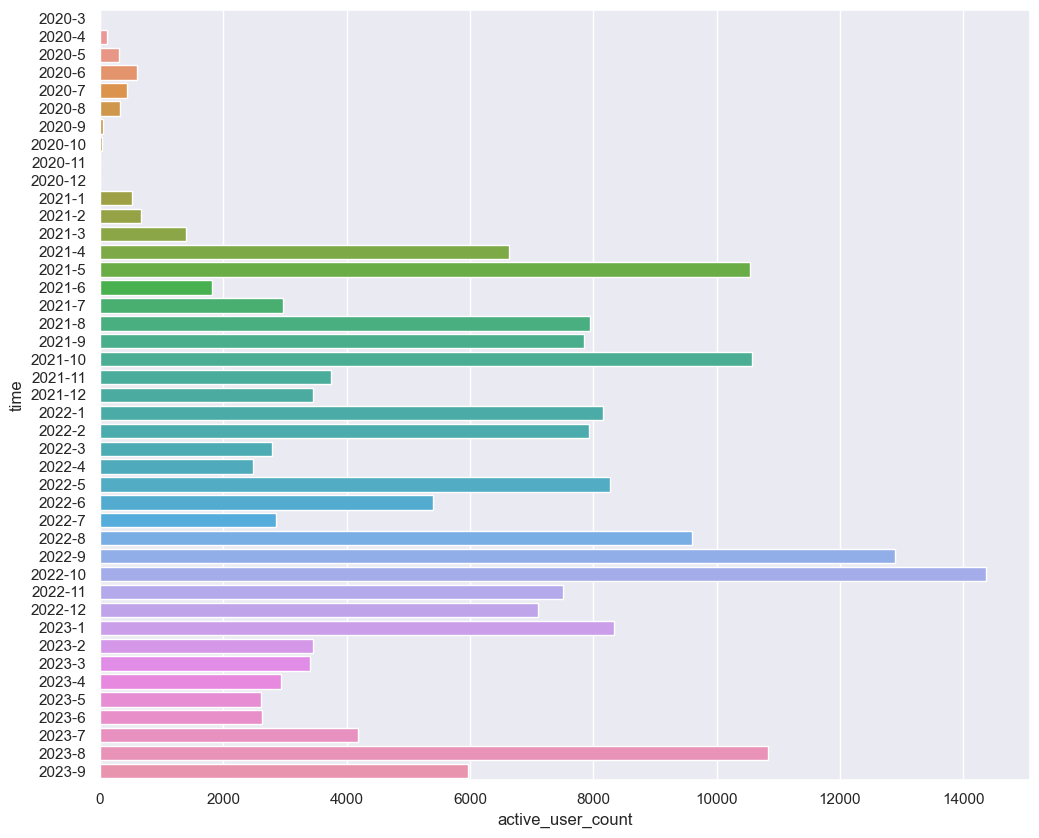

In [19]:
sns.barplot(x = 'active_user_count', y = 'time', data=active_user_count_ds, orient='h', estimator="sum", errorbar=None)

c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


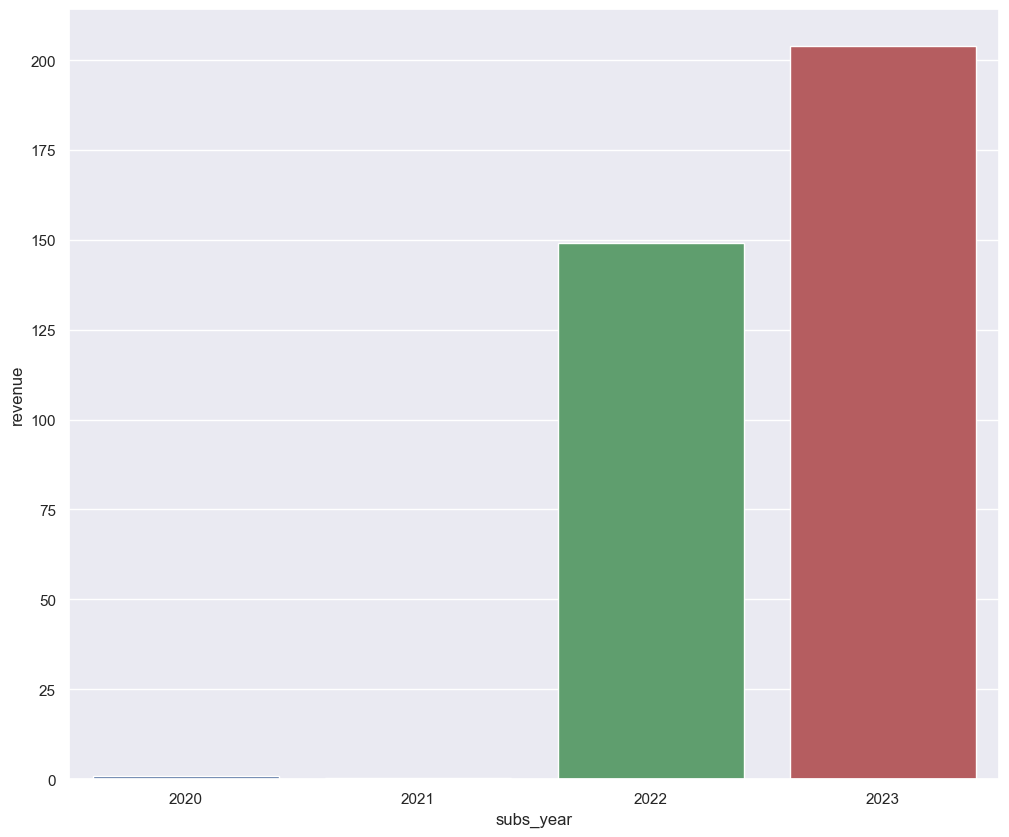

In [20]:
subscriptions_mds['subs_year'] = subscriptions_mds['subs_date'].dt.year
sns.barplot(x='subs_year',y='revenue',data=subscriptions_mds[['subs_year', 'revenue']].groupby('subs_year').mean().reset_index())
plt.show()

c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


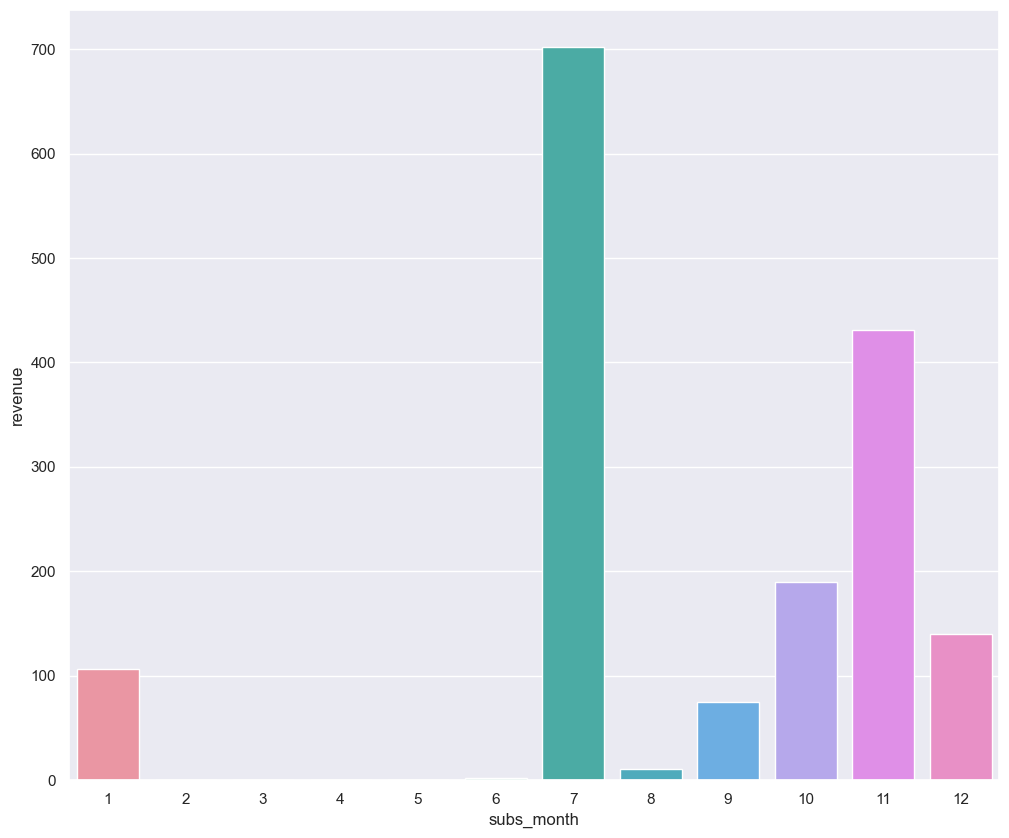

In [21]:
subscriptions_mds['subs_month'] = subscriptions_mds['subs_date'].dt.month
sns.barplot(x='subs_month',y='revenue',data=subscriptions_mds[['subs_month', 'revenue']].groupby('subs_month').mean().reset_index())
plt.show()

In [22]:
subscriptions_mds

,country,operator,source,msisdn,cycle,revenue,subs_date,renewal_date,freemium_end_date,unsubs_date,service_price,currency,attempt_charging,success_billing,subs_date_month,subs_date_hour,subs_date_hour_local,revenue_converted,service_price_converted,success_billing_rate,years_subscribed,status,source_encoded,country_encoded,operator_encoded,cycle_encoded,success_billing_rate_binned,subs_year,subs_month
0,TH,ais,sms,66988602911,daily,0.0,2022-10-20 19:28:02,2023-09-14 00:00:00,2022-10-20,NaT,6,BATH,15,0,10,19,19,0.0,2640.0,0.000000,0.945723,1,7,3,0,0,bad,2022,10
1,TH,ais,sms,66822243080,daily,0.0,2020-08-23 16:11:02,2023-09-14 00:00:00,2020-08-23,NaT,6,BATH,15,0,8,16,16,0.0,2640.0,0.000000,3.105002,1,7,3,0,0,bad,2020,8
3,TH,ais,wap,66650020857,daily,0.0,2023-09-09 13:03:24,2023-09-14 00:00:00,2023-09-09,NaT,6,BATH,5,0,9,13,13,0.0,2640.0,0.000000,0.058783,1,8,3,0,0,bad,2023,9
4,TH,ais,sms,66635959286,daily,0.0,2022-09-26 19:36:03,2023-09-14 00:00:00,2022-09-26,NaT,6,BATH,15,0,9,19,19,0.0,2640.0,0.000000,1.011461,1,7,3,0,0,bad,2022,9
5,TH,ais,sms,66931235277,daily,0.0,2021-08-06 16:27:07,2023-09-14 00:00:00,2021-08-06,NaT,6,BATH,15,0,8,16,16,0.0,2640.0,0.000000,2.151547,1,7,3,0,0,bad,2021,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294907,OM,omantel,cp1,96899385640,daily,37500.0,2023-01-08 08:11:33,2023-05-12 06:23:11,NaT,NaT,300,RIAL,125,125,1,8,5,146250000.0,1170000.0,1.000000,0.727832,1,2,1,2,0,good,2023,1
294908,OM,omantel,cp1,96899692670,daily,24900.0,2023-01-08 07:43:45,2023-05-12 06:20:31,NaT,NaT,300,RIAL,84,83,1,7,4,97110000.0,1170000.0,0.988095,0.727885,1,2,1,2,0,good,2023,1
294909,OM,omantel,cp1,96891308962,daily,0.0,2023-01-08 12:23:17,2023-01-08 12:25:07,NaT,2023-03-10 03:07:13,300,RIAL,1,0,1,12,9,0.0,1170000.0,0.000000,0.166065,-1,2,1,2,0,bad,2023,1
294910,OM,omantel,cp1,96891246065,daily,1800.0,2023-01-08 16:56:17,2023-04-19 05:55:05,NaT,NaT,300,RIAL,7,6,1,16,13,7020000.0,1170000.0,0.857143,0.726834,1,2,1,2,0,good,2023,1


In [23]:
subscriptions_mds['subs_date_year'] = subscriptions_mds['subs_date'].dt.year
subscriptions_mds['subs_date_month'] = subscriptions_mds['subs_date'].dt.month
subscriptions_mds['subs_date_day'] = subscriptions_mds['subs_date'].dt.day

c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


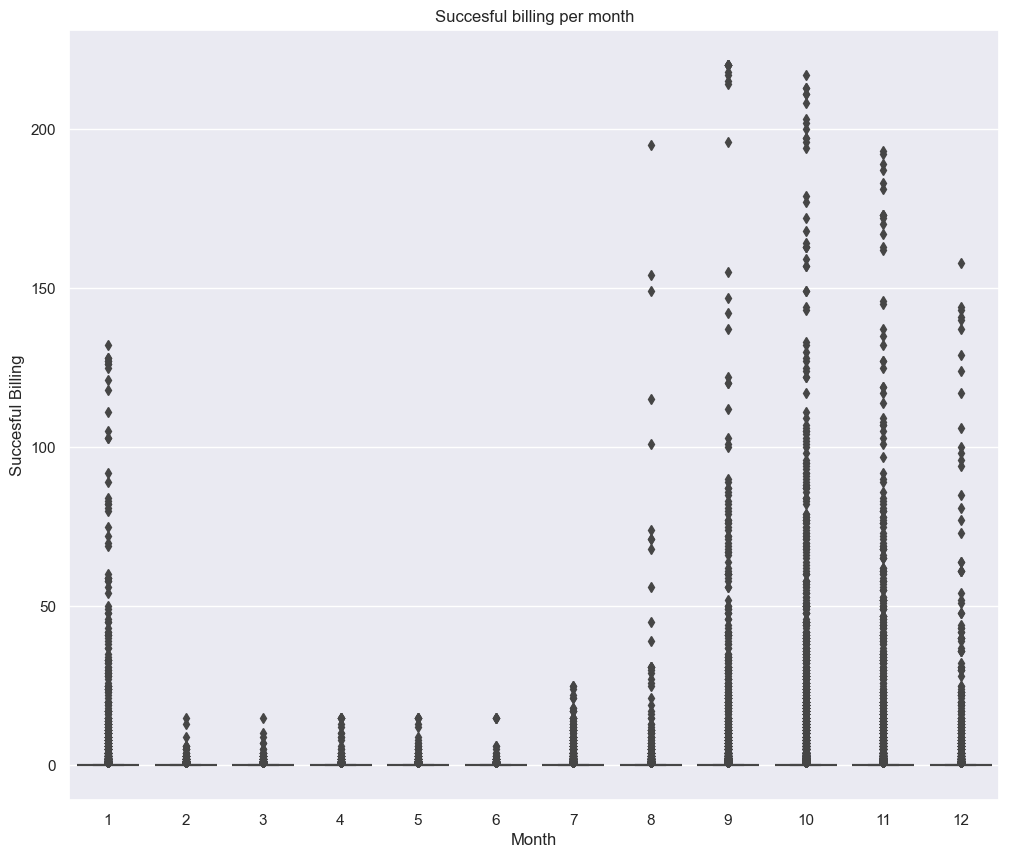

In [24]:
sns.boxplot(x='subs_date_month',y='success_billing',data=subscriptions_mds[['subs_date_month', 'success_billing']])
plt.title('Succesful billing per month')
plt.xlabel('Month')
plt.ylabel('Succesful Billing')
plt.show()

In [25]:
# sns.countplot(x='years_subscribed',data=subscriptions_mds.drop(subscriptions_mds[subscriptions_mds['years_subscribed'] == -1].index))
# plt.title('Duration of subscription')
# plt.xlabel('Years subscribed')

# plt.show()

c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


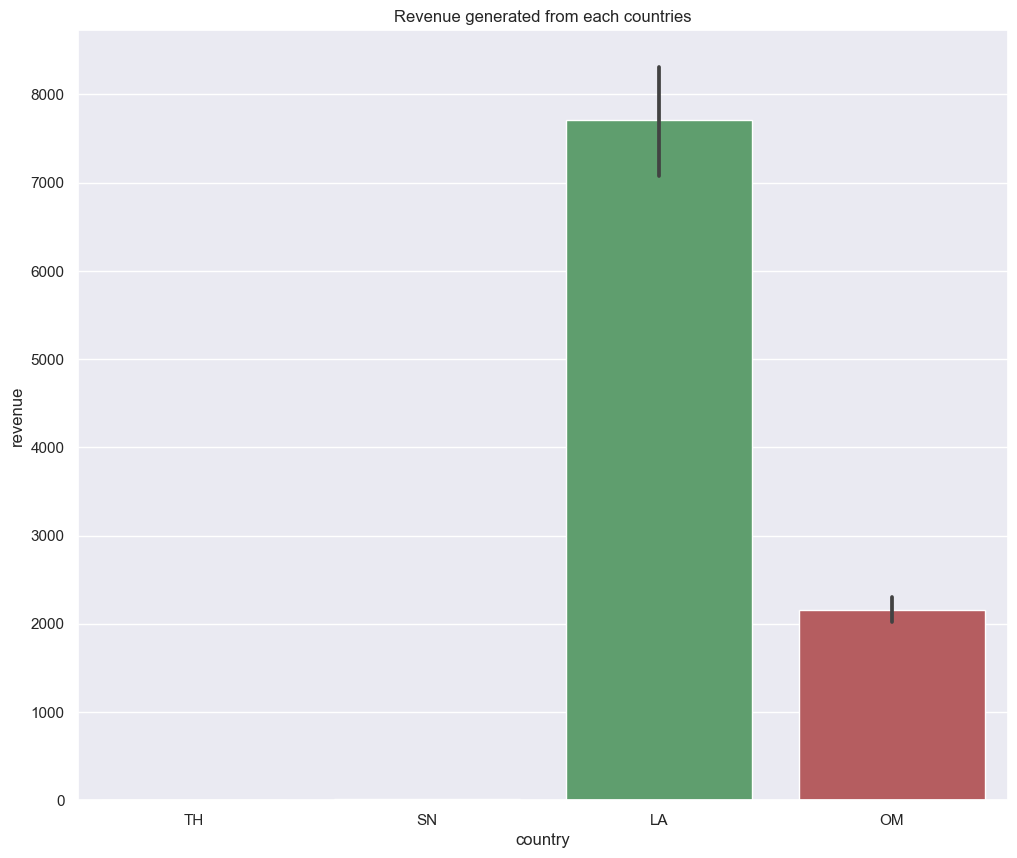

In [26]:

sns.barplot(x='country',y='revenue',data=subscriptions_mds)

plt.title('Revenue generated from each countries')

plt.show()

# Transaction

In [27]:
transactions_rds.columns

Index(['id', 'created_at', 'country', 'operator', 'service', 'source',
       'msisdn', 'event', 'event_date', 'cycle', 'revenue', 'currency',
       'charge_date', 'publisher', 'handset', 'browser', 'trxid',
       'telco_api_url', 'telco_api_response', 'sms_content', 'status_sms'],
      dtype='object')

In [28]:
transactions_rds[transactions_rds['sms_content'].notnull()][['sms_content']]

,sms_content
1356,Enjoy your favourite song from GMM in clicksml...
1357,Enjoy your favourite song from GMM in clicksml...
1358,Enjoy your favourite song from GMM in clicksml...
1359,Enjoy your favourite song from GMM in clicksml...
1360,Enjoy your favourite song from GMM in clicksml...
...,...
201353,Play latest game in gamefun.mobi login with th...
201354,Enjoy your favourite song from GMM in clicksml...
201355,Enjoy your favourite song from GMM in clicksml...
234154,_1


In [29]:

transactions_rds[transactions_rds['telco_api_url'].notnull()][['telco_api_url']]

,telco_api_url
1356,https://c.mconnect4u.com/smsexternalapi/apiser...
1357,https://c.mconnect4u.com/smsexternalapi/apiser...
1358,https://c.mconnect4u.com/smsexternalapi/apiser...
1359,https://c.mconnect4u.com/smsexternalapi/apiser...
1360,https://c.mconnect4u.com/smsexternalapi/apiser...
...,...
505425,http://182.16.255.85:8093/ETLPaymentTopup/serv...
505426,http://182.16.255.85:8093/ETLPaymentTopup/serv...
505427,http://182.16.255.85:8093/ETLPaymentTopup/serv...
505428,http://182.16.255.85:8093/ETLPaymentTopup/serv...


In [30]:
transactions_mds = transactions_rds.drop(columns = ['currency', 'browser', 'handset','sms_content'])

In [31]:
transactions_mds['event_date'] = pd.to_datetime(transactions_mds ['event_date'], errors='coerce')
transactions_mds['charge_date'] = pd.to_datetime(transactions_mds['charge_date'], errors='coerce')
transactions_mds['created_at'] = pd.to_datetime(transactions_mds['created_at'], errors='coerce')
transactions_mds['id'] = transactions_mds['id'].astype(int)
transactions_mds['status_sms'] = transactions_mds['status_sms'] == 1

transactions_mds['revenue'] = pd.to_numeric(transactions_mds['revenue'], errors='coerce', downcast='integer')
transactions_mds.dropna(subset=['revenue'], inplace=True)
transactions_mds = transactions_mds.astype({'revenue' : 'int32'})

In [32]:
transactions_mds.dtypes

id                             int32
created_at            datetime64[ns]
country                       object
operator                      object
service                       object
source                        object
msisdn                        object
event                         object
event_date            datetime64[ns]
cycle                         object
revenue                        int32
charge_date           datetime64[ns]
publisher                     object
trxid                         object
telco_api_url                 object
telco_api_response            object
status_sms                      bool
dtype: object

In [33]:
transactions_rds.info()
transactions_rds[transactions_rds['sms_content'].notnull()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505430 entries, 0 to 505429
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  505430 non-null  int64 
 1   created_at          505430 non-null  object
 2   country             505430 non-null  object
 3   operator            505430 non-null  object
 4   service             505430 non-null  object
 5   source              504074 non-null  object
 6   msisdn              505430 non-null  object
 7   event               505430 non-null  object
 8   event_date          505430 non-null  object
 9   cycle               505430 non-null  object
 10  revenue             505430 non-null  object
 11  currency            504074 non-null  object
 12  charge_date         505430 non-null  object
 13  publisher           304074 non-null  object
 14  handset             261426 non-null  object
 15  browser             304072 non-null  object
 16  tr

,id,created_at,country,operator,service,source,msisdn,event,event_date,cycle,revenue,currency,charge_date,publisher,handset,browser,trxid,telco_api_url,telco_api_response,sms_content,status_sms
1356,1723390,2023-09-13 18:45:27.505,TH,ais,459505104,sms,66612754553,Renewal,2023-09-03 08:55:10.000,daily,0,BATH,2023-09-03 08:55:10.000,NaN,NaN,NaN,2.02309E+19,https://c.mconnect4u.com/smsexternalapi/apiser...,<return><status>OK</status><gmid>2023090308424...,Enjoy your favourite song from GMM in clicksml...,SENT
1357,1723432,2023-09-13 18:45:27.523,TH,ais,459505104,sms,66984053432,Renewal,2023-09-03 08:55:08.000,daily,0,BATH,2023-09-03 08:55:08.000,NaN,NaN,NaN,2.02309E+19,https://c.mconnect4u.com/smsexternalapi/apiser...,<return><status>OK</status><gmid>2023090308424...,Enjoy your favourite song from GMM in clicksml...,SENT
1358,1723221,2023-09-13 18:45:27.431,TH,ais,459505104,sms,66621106945,Renewal,2023-09-03 08:55:06.000,daily,0,BATH,2023-09-03 08:55:06.000,NaN,NaN,NaN,2.02309E+19,https://c.mconnect4u.com/smsexternalapi/apiser...,<return><status>OK</status><gmid>2023090308424...,Enjoy your favourite song from GMM in clicksml...,SENT
1359,1723525,2023-09-13 18:45:27.564,TH,ais,459505104,sms,66650512296,Renewal,2023-09-03 08:55:10.000,daily,0,BATH,2023-09-03 08:55:10.000,NaN,NaN,NaN,2.02309E+19,https://c.mconnect4u.com/smsexternalapi/apiser...,<return><status>OK</status><gmid>2023090308424...,Enjoy your favourite song from GMM in clicksml...,SENT
1360,1723499,2023-09-13 18:45:27.557,TH,ais,459505104,sms,66856862589,Renewal,2023-09-03 08:55:10.000,daily,0,BATH,2023-09-03 08:55:10.000,NaN,NaN,NaN,2.02309E+19,https://c.mconnect4u.com/smsexternalapi/apiser...,<return><status>OK</status><gmid>2023090308424...,Enjoy your favourite song from GMM in clicksml...,SENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201353,3658578,2023-09-13 20:40:37.700,TH,ais,459505106,wap,66987615704,Renewal,2023-09-07 08:17:41.000,daily,0,BATH,2023-09-07 08:17:41.000,NaN,NaN,NaN,20230900000000000000.0,https://c.mconnect4u.com/smsexternalapi/apiser...,<return><status>OK</status><gmid>2023090707174...,Play latest game in gamefun.mobi login with th...,SENT
201354,3260031,2023-09-13 20:17:03.302,TH,ais,459505104,sms,66635827510,Renewal,2023-09-07 07:08:48.000,daily,0,BATH,2023-09-07 07:08:48.000,NaN,NaN,NaN,20230900000000000000.0,https://c.mconnect4u.com/smsexternalapi/apiser...,<return><status>OK</status><gmid>2023090707021...,Enjoy your favourite song from GMM in clicksml...,SENT
201355,3260037,2023-09-13 20:17:03.320,TH,ais,459505104,sms,66631486876,Renewal,2023-09-07 07:08:46.000,daily,0,BATH,2023-09-07 07:08:46.000,NaN,NaN,NaN,20230900000000000000.0,https://c.mconnect4u.com/smsexternalapi/apiser...,<return><status>OK</status><gmid>2023090707021...,Enjoy your favourite song from GMM in clicksml...,SENT
234154,33217,2023-09-13 16:40:41.588,OM,omantel,goaly,cp1,96899685063,notif@renew,2022-12-12 05:37:05.000,daily,300,Rial,2022-12-12 05:37:05.000,lumos,/,Apache-HttpClient,NaN,/api/notif/renewal/4782,DELIVERED,_1,_2


In [34]:
print(transactions_rds.columns)

Index(['id', 'created_at', 'country', 'operator', 'service', 'source',
       'msisdn', 'event', 'event_date', 'cycle', 'revenue', 'currency',
       'charge_date', 'publisher', 'handset', 'browser', 'trxid',
       'telco_api_url', 'telco_api_response', 'sms_content', 'status_sms'],
      dtype='object')


In [35]:
print(transactions_mds.columns)


Index(['id', 'created_at', 'country', 'operator', 'service', 'source',
       'msisdn', 'event', 'event_date', 'cycle', 'revenue', 'charge_date',
       'publisher', 'trxid', 'telco_api_url', 'telco_api_response',
       'status_sms'],
      dtype='object')


In [36]:
transactions_mds['country'].unique()

array(['TH', 'th', 'OM', 'LA'], dtype=object)

c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

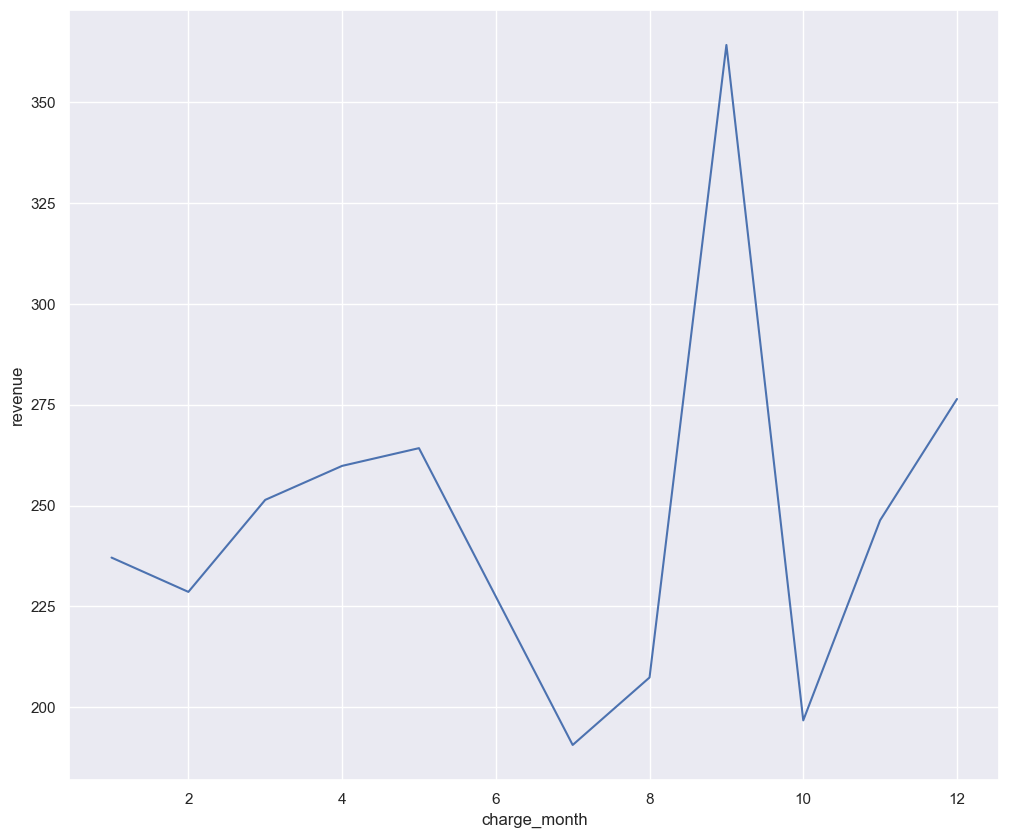

In [37]:
transactions_mds['charge_month'] = transactions_mds['charge_date'].dt.month
sns.lineplot(x='charge_month',y='revenue',data=transactions_mds[['charge_month', 'revenue']].groupby('charge_month').mean().reset_index())
plt.show()

c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


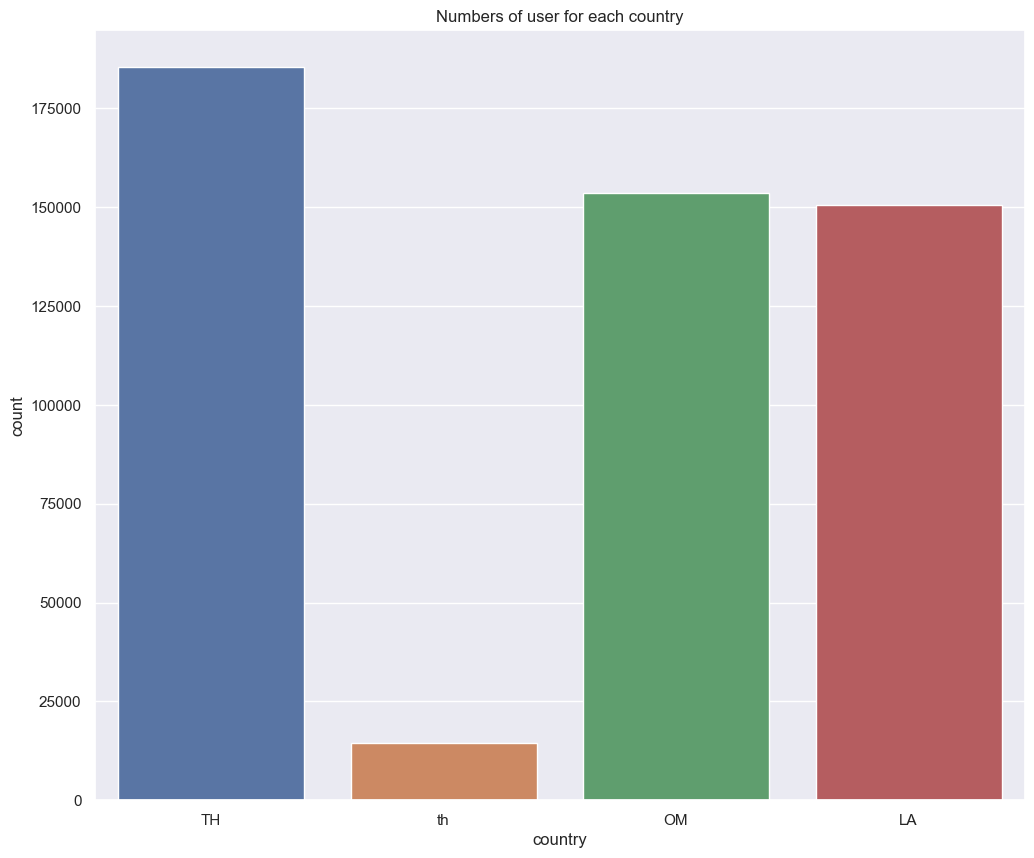

In [38]:
sns.countplot(x='country',data=transactions_mds)
plt.title('Numbers of user for each country')
plt.show()


c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


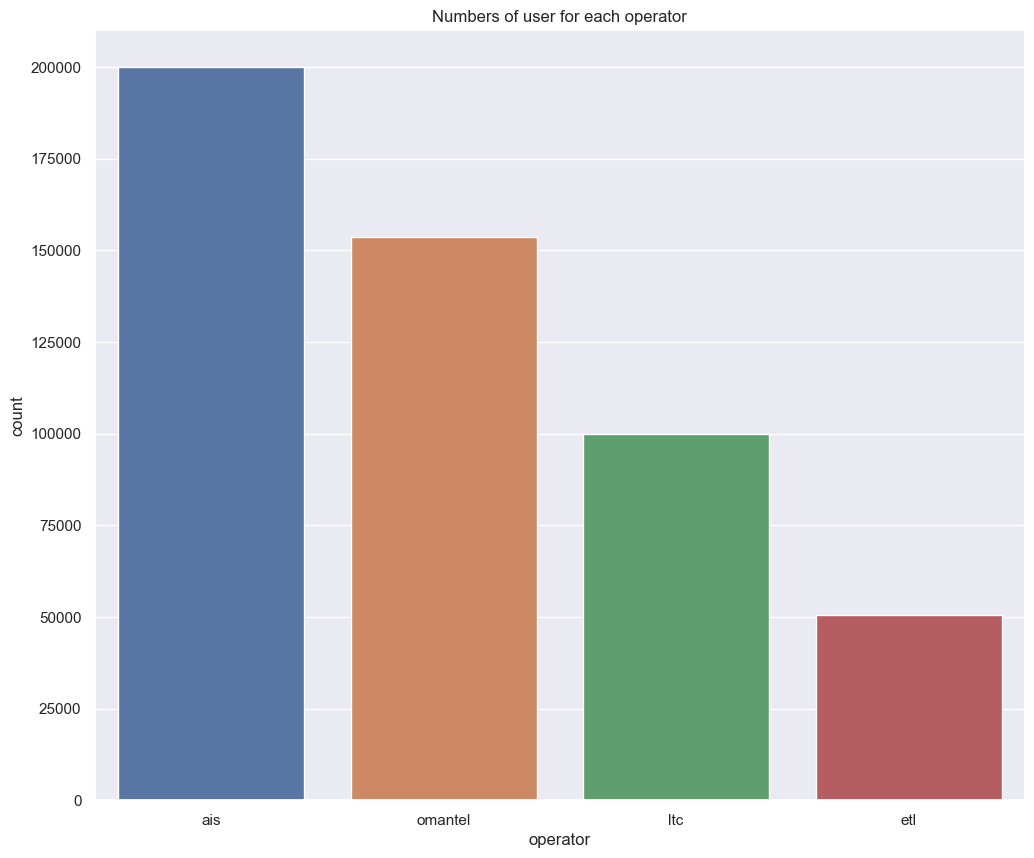

In [39]:
sns.countplot(x='operator',data=transactions_mds)
plt.title('Numbers of user for each operator')
plt.show()

c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


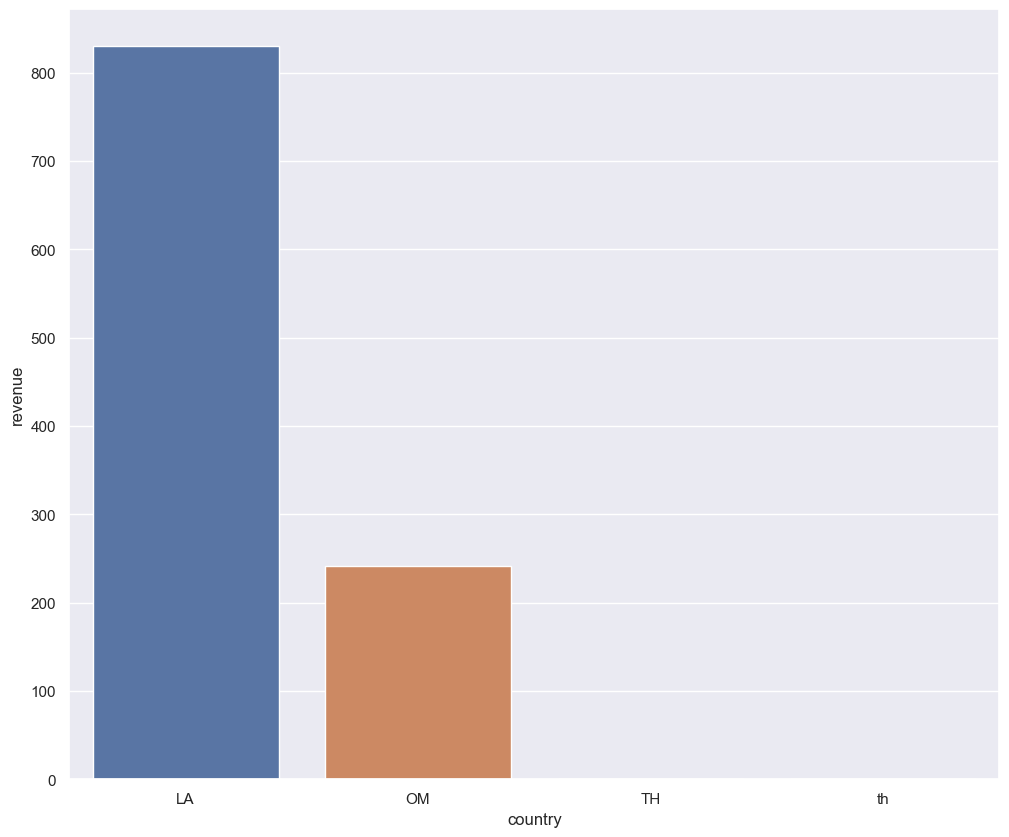

In [40]:
sns.barplot(x='country',y='revenue',data=transactions_mds[['country', 'revenue']].groupby('country').mean().reset_index())
plt.show()

<Axes: title={'center': 'revenue'}, xlabel='country'>

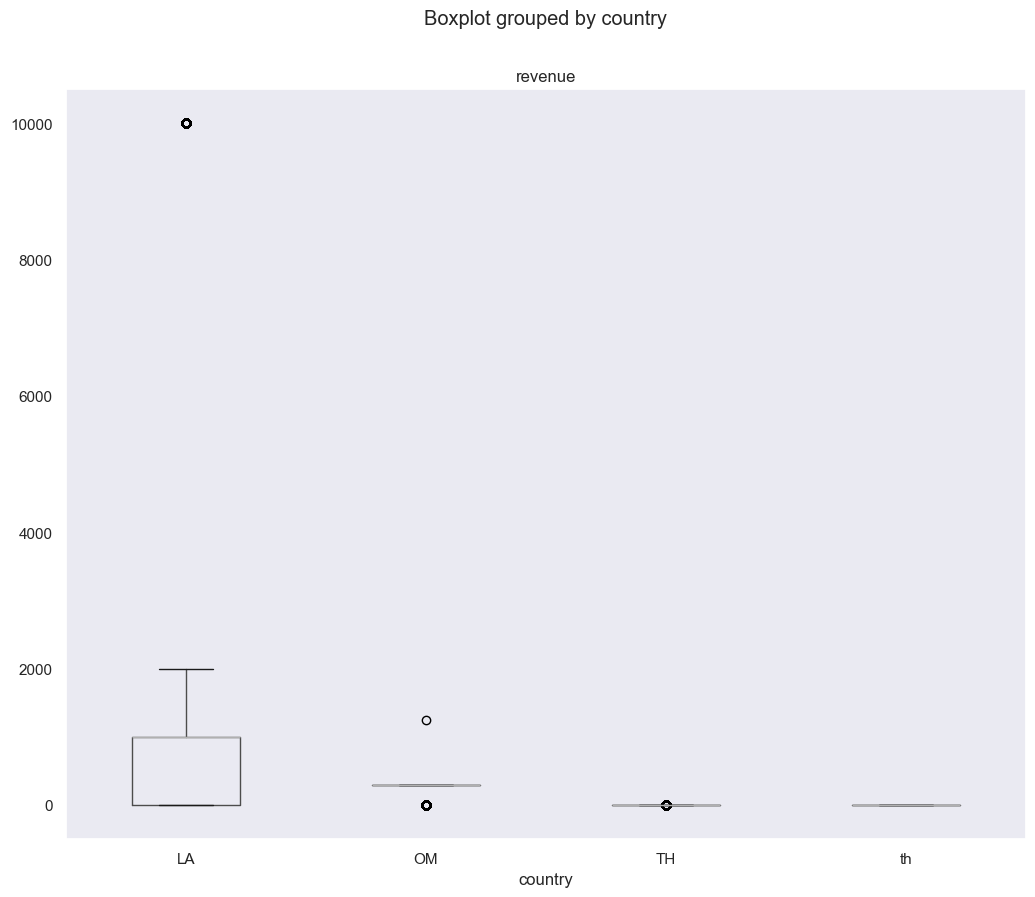

In [41]:

transactions_mds.boxplot(by ='country', column =['revenue'], grid = False) 

c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Michail\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


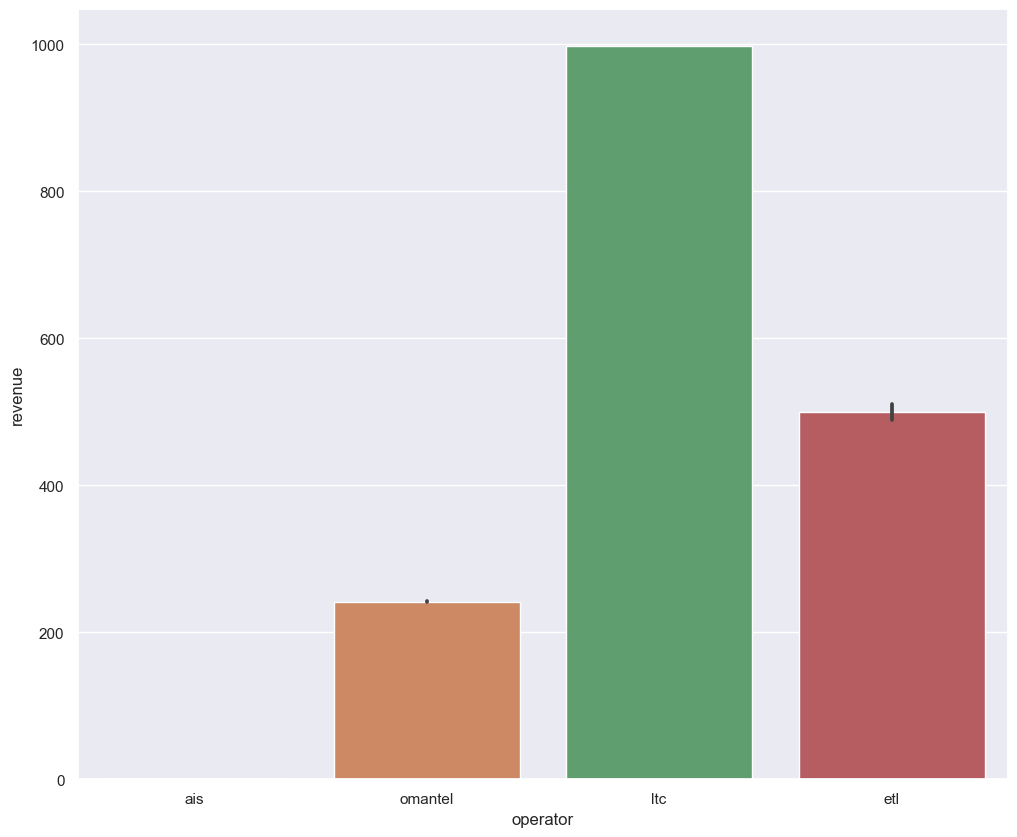

In [42]:
sns.barplot(x='operator',y='revenue',data=transactions_mds)
plt.show()